In [1]:
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import layers 
from tensorflow.keras import models 
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
from scipy.stats import lognorm
from scipy.stats import norm

/home/sean/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sean/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sean/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/sean/anaconda3/envs/tf-gpu-c

In [2]:
train_data = pd.read_csv('./train.csv')
test_data = pd.read_csv('./test.csv')
cut = 1300
train_data_x , train_data_y  = train_data.iloc[:cut,1:-1].copy(), train_data.iloc[:cut,-1].copy()
val_data_x , val_data_y = train_data.iloc[cut:,1:-1].copy(), train_data.iloc[cut:,-1].copy()
test_data_x  = test_data


In [3]:
def gaus(x, mean,std):##Gaussian
    return 1/(std*(2*np.pi)**0.5)*np.exp(-0.5*((x-mean)/std)**2)

def bin_bisect(bins):## Bin Bisector 
    bisects = np.zeros(len(bins)-1)
    for i in range(len(bins)-1):
        bisects[i] = (bins[i]+bins[i+1])/2
    return(bisects)

def rss(observed,expected):##Chisquared value 
    return(np.sum((observed-expected)**2))

All numerical data can be easily normalized. 
for the non nunmerical entries, The number of unique entries should be considered. 

To Do
-Plot input data 
-stdev

180983.51461538463
1.2151782995734465e-11
1.5721638628623447e-10


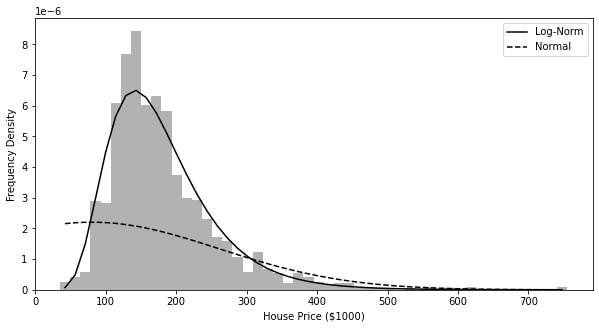

In [4]:
fig = plt.figure(figsize=(10,5))
vals, bins , _ = plt.hist(train_data_y,50, density= True, color = 'black', alpha = 0.3)

##variables stuff
bin_bisects = bin_bisect(bins)
sigma, mean, scale = lognorm.fit(train_data_y)
sigma_norm, mean_norm = np.mean(train_data_y), np.std(train_data_y)
fit_norm = gaus(bin_bisects,mean_norm,sigma_norm)
fit = lognorm.pdf(bin_bisects, sigma, scale = scale)

print(np.mean(train_data_y))
##Plotting 


plt.plot(bin_bisects, fit, c = 'black', label = 'Log-Norm')
plt.plot(bin_bisects, fit_norm, c = 'black',linestyle = '--', label = 'Normal')
plt.xticks(range(0,800000,100000),range(0,800,100))
plt.xlabel('House Price ($1000)')
plt.ylabel('Frequency Density')
## Fits 
print(rss(vals,fit))
print(rss(vals,fit_norm))
plt.legend()
fig.savefig('../Kaggle_Housing_Figures/Data_Dist.png',dpi = 300)

In [5]:
###Finding MAE with random variables distributed according to the pdf 

random_variable = lognorm.rvs(sigma,loc = mean,size = len(val_data_y)*1000,scale = scale)
rv_mean = np.zeros(1000)
for i in range(1000):
    chunk = random_variable[160*i:160*(i+1)]
    rv_mean[i] = np.mean(abs(val_data_y -random_variable[160*i:160*(i+1)]))

print(np.mean(rv_mean))
print(np.std(rv_mean))

80391.86255758676
4752.366233511897


## Functions For Processing Input data 
Data is normalised either with some form of gaussian or between 0-1 depending on what it is

I am going to remove the top 5% of house prices. I think that ftting a lognorm dist is going to be the best bet for this. 

In [6]:
##excluding top 5%
#index = np.where(train_data_y < np.percentile(train_data_y,95))

#train_data_y , train_data_x    = train_data_y.iloc[index], train_data_x.iloc[index]
#train_data_x  = np.delete(train_data_x,drop_index)


In [7]:
def atributes_to_int(series):
    unique_ent = pd.unique(series)
    num_unique_ent = len(unique_ent)
    for i in range(num_unique_ent):
        index = np.where(unique_ent[i] == series)
        series.iloc[index] = i
    return series/num_unique_ent ### I divided by the number of unique entries so that all the values in the input columns are between 0-1

def normalise(series):
    mean = np.mean(series)
    std = np.std(series)
    if std == 0:
        return (series - mean)
    else:
        return((series - mean)/std)

def column_processor(series):
    
    #series = series.fillna(0)
    if series.dtype == object:
        norm_series = atributes_to_int(series)
    if series.dtype == int or float:
        norm_series = normalise(series)
    return norm_series

def process_input_data(data):
    data = data.fillna(0)
    for i in range(len(data.iloc[0])):
        data.iloc[:,i] = column_processor(data.iloc[:,i])
    return data
def expn_smooth(function,smoothing_param):
    smoothed_function = np.zeros_like(function)
    smoothed_function[0] = function[0]
    for i in range(1,len(function)):
        smoothed_function[i] = function[i]*(smoothing_param)+(1-smoothing_param)*smoothed_function[i-1]
    return smoothed_function

In [8]:
train_data_x = process_input_data(train_data_x)
val_data_x = process_input_data(val_data_x)

/home/sean/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [9]:
print(pd.unique(train_data_x['Alley']))
#print(train_data_x.columns)

[-0.23661361647023868 2.509794431845032 5.256202480160303]


## Neural Net

In [10]:
def build_model(num_layers,layer_size):
    model = models.Sequential()
    model.add(layers.Dense(layer_size[0],activation= 'relu',input_shape = (train_data_x.shape[1],)))
    for i in range(1,num_layers):
        model.add(layers.Dense(layer_size[i],activation = 'relu'))
    model.add(layers.Dense(1))
    opt = keras.optimizers.SGD(learning_rate= .01)
    model.compile(optimizer = opt,loss = 'mse', metrics = ['mae'])
    return model

In [11]:
model = build_model(2,[128,128])
history = model.fit(train_data_x,train_data_y, validation_data= (val_data_x,val_data_y),epochs = 100,batch_size = 80,verbose = 0)


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


2021-10-23 14:07:41.309564: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2021-10-23 14:07:41.339735: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 3700155000 Hz
2021-10-23 14:07:41.340780: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55ffd83b6c90 executing computations on platform Host. Devices:
2021-10-23 14:07:41.341055: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): <undefined>, <undefined>
2021-10-23 14:07:41.343121: I tensorflow/stream_executor/platform/default/dso_loader.cc:42] Successfully opened dynamic library libcuda.so.1
2021-10-23 14:07:41.369967: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1005] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-23 14:07:41.370461: I tensorflow/cor

In [12]:
start = 30
mae = history.history['val_mean_absolute_error']
print(np.min(mae))
mae = mae[start:]

epochs = range(1,101)
epochs = epochs[start:]
train_err = history.history['loss']
train_err = train_err[start:]

56916.805


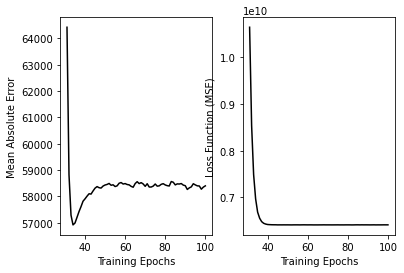

In [13]:
fig, axs = plt.subplots(1,2,)
axs[0].plot(epochs,mae, label = 'Mean Absolute Error', c = 'black')
axs[1].plot(epochs,train_err, label = 'Loss Function',c = 'black')

axs[0].set_ylabel('Mean Absolute Error')
axs[1].set_ylabel('Loss Function (MSE)')
axs[0].set_xlabel('Training Epochs')
axs[1].set_xlabel('Training Epochs')
fig.savefig('../Kaggle_Housing_Figures/Inital Test.png',dpi = 300)


Using the adam optimiser, which is like rsmprop, but with a momentum effect does reduce the error faster. Editing the learning rate to 0.1 gives a much faster fitting.  

In [14]:
start  = 
mae_slice  = mae[start:]
epochs_slice = epochs[start:]
plt.plot(epochs_slice,mae_slice)
print(np.min(mae))


SyntaxError: invalid syntax (3813421608.py, line 1)

Editing Hyperparams to see if I can get a better value than for 256,256

In [ ]:
def hyperparam_investigator(epoch_num, layer_num,layer_shape,start = 0):
    
    model = build_model(layer_num,layer_shape)
    history = model.fit(train_data_x,train_data_y, validation_data= (val_data_x,val_data_y),epochs = epoch_num ,batch_size = 80,verbose = 1)
    mae = (history.history['val_mean_absolute_error'])
    train_err = history.history['loss']
    epochs = range(1,epoch_num+1)
    return [mae , train_err , epochs] 
    
def plotter(hyperparam_investigator_out,mae_smooth = .25, train_err_smooth = 0.25, start_mae = 0,start_train = 0 ):
    mae = expn_smooth(hyperparam_investigator_out[0], mae_smooth)
    train_err = expn_smooth(hyperparam_investigator_out[1], train_err_smooth)
    epochs = hyperparam_investigator_out[2]
    fig ,axs = plt.subplots(1,2, figsize = (10,5))
    axs[0].set_ylabel('Mean Absolute Error')
    axs[0].set_xlabel('Epochs')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Loss Function')
    mae_slice  = mae[start_mae:]
    train_err_slice = train_err[start_train:]
    epochs_slice_train = epochs[start_train:]
    epochs_slice_mae = epochs[start_mae:]
    axs[0].plot(epochs_slice_mae,mae_slice)
    axs[1].plot(epochs_slice_train,train_err_slice)
    print(np.min(mae))


In [ ]:
test = hyperparam_investigator(300,2,[64,64])

Train on 1300 samples, validate on 160 samples
Epoch 1/300
1300/1300 [==============================] - 0s 145us/sample - loss: 368462892225779073024.0000 - mean_absolute_error: 5112946688.0000 - val_loss: 963995170385166336.0000 - val_mean_absolute_error: 981832576.0000
Epoch 2/300
1300/1300 [==============================] - 0s 22us/sample - loss: 721017268488327808.0000 - mean_absolute_error: 845347136.0000 - val_loss: 485021895003996160.0000 - val_mean_absolute_error: 696435200.0000
Epoch 3/300
1300/1300 [==============================] - 0s 20us/sample - loss: 362770849816076928.0000 - mean_absolute_error: 599623040.0000 - val_loss: 244032474026344448.0000 - val_mean_absolute_error: 493996448.0000
Epoch 4/300
1300/1300 [==============================] - 0s 22us/sample - loss: 182523541155552128.0000 - mean_absolute_error: 425325504.0000 - val_loss: 122781638840025088.0000 - val_mean_absolute_error: 350402112.0000
Epoch 5/300
1300/1300 [==============================] - 0s 21us/sam

58329.812


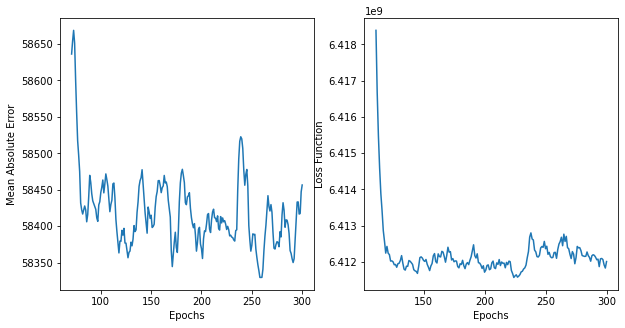

In [ ]:
plotter(test, start_mae = 70,start_train= 110)


nan


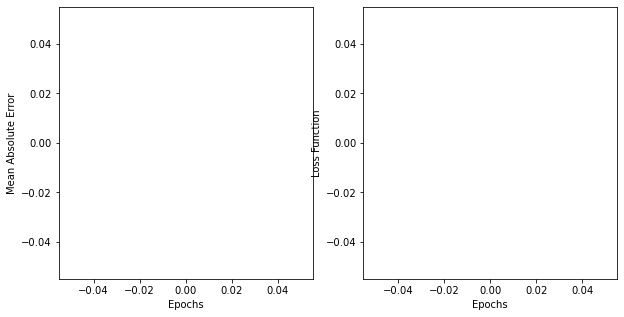

In [ ]:
hyperparam_investigator(300,2,[128,128])

Adding a further Layer did not help with minimising the mae, I think just fiddling with the hyperparameters this evening is going to be a good idea

nan
56927.15


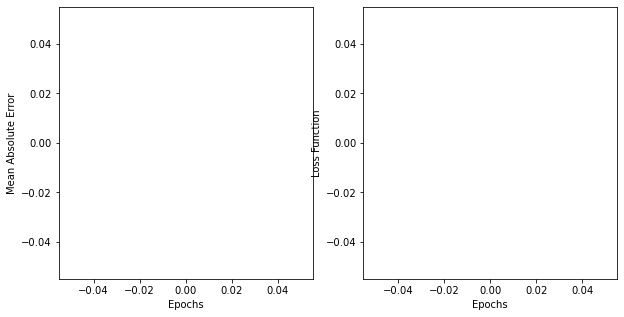

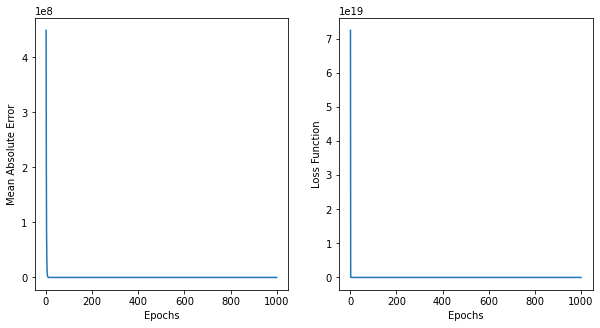

In [ ]:
hyperparam_investigator(300,3,[128,128,128])
hyperparam_investigator(1000,2,[64,64])

This is worth keeping clearly shows the overtraining. The results are worse than the first test. This is probably due to the lack of degrees of freedom that this model has. 

nan


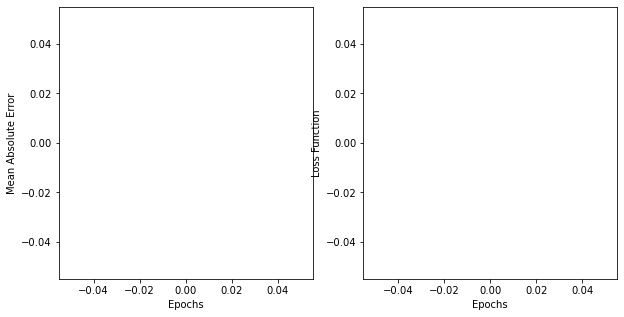

In [ ]:
hyperparam_investigator(1000,2,[128*3,128*3])

I think that this minimum is anomalous and this larger network is not the solution 

nan


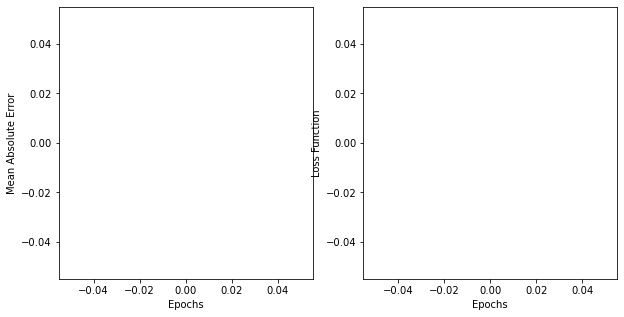

In [ ]:
hyperparam_investigator(500,2,[256,256])